# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

**⚠️ DISCLAIMER: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results. Always double-check findings and analyses. ⚠️**

## Overview of the Dandiset

This notebook explores [Dandiset 001366 (version 0.250324.1603)](https://dandiarchive.org/dandiset/001366/0.250324.1603), which contains imaging data for comparing different approaches to quantifying blood vessel diameter and pulsatility in mice. The dataset includes movies of pial vessels (blood vessels on the surface of the brain) that can be analyzed to measure vessel diameters and how they change over time.

### Key Information:

- **Title:** Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification
- **Contributors:** Zhao, Yue; Ranjan, Aditya; Wong, Devin T.; Huang, Qinwen; Ghanizada, Hashmat; Nedergaard, Maiken; Kelley, Douglas H.; Boster, Kimberly A. S.
- **Description:** Movies of pial vessels of mice used in experiments
- **Keywords:** full width at half maximum, vessel pulsation, image analysis, vessel diameter, radon transform
- **License:** CC-BY-4.0

### What This Notebook Covers:

1. Loading and examining the NWB (Neurodata Without Borders) files in the Dandiset
2. Exploring the vessel imaging data
3. Implementing and comparing methods for vessel diameter measurement
4. Analyzing vessel pulsatility over time
5. Visualizing the results

## Required Packages

The following packages are required to run this notebook:

- `pynwb` - For reading NWB files
- `h5py` - For working with HDF5 files (used by NWB)
- `remfile` - For remote file access
- `numpy` - For numerical operations
- `matplotlib` - For plotting
- `scipy` - For image processing and signal analysis
- `seaborn` - For enhanced visualizations

In [1]:
# Import required packages
import pynwb
import h5py
import remfile
import numpy as np
from scipy import ndimage, signal
import matplotlib.pyplot as plt
from itertools import islice
from dandi.dandiapi import DandiAPIClient
import seaborn as sns

# Set up styling for plots
sns.set_theme()

## Loading the Dandiset

First, we'll connect to the DANDI archive and access the Dandiset metadata. This will give us an overview of what's available in this dataset.

In [2]:
# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001366", "0.250324.1603")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List assets in the Dandiset
assets = dandiset.get_assets()
print("\nAssets in the Dandiset:")
for asset in islice(assets, 5):  # Show first 5 assets
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification
Dandiset URL: https://dandiarchive.org/dandiset/001366/0.250324.1603

Assets in the Dandiset:
- sub-F15/sub-F15_ses-F15BC-19102023_image.nwb (ID: 71fa07fc-4309-4013-8edd-13213a86a67d)
- sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb (ID: 2f12bce3-f841-46ca-b928-044269122a59)


## Loading and Exploring an NWB File

Now we'll load one of the NWB files and explore its contents. We'll focus on the file containing vessel imaging data.

In [3]:
# Load an NWB file from the Dandiset
# We'll use the smaller file for faster processing
url = "https://api.dandiarchive.org/api/assets/71fa07fc-4309-4013-8edd-13213a86a67d/download/"
print(f"Loading NWB file from URL: {url}")

remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the NWB file
print(f"\nNWB file identifier: {nwb.identifier}")
print(f"Session description: {nwb.session_description[:100]}...")
print(f"Experiment description: {nwb.experiment_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Institution: {nwb.institution}")

# Print subject information
subject = nwb.subject
print(f"\nSubject information:")
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Age: {subject.age}")
print(f"Sex: {subject.sex}")
print(f"Description: {subject.description}")

# Look at the file structure
print("\nAvailable groups in the NWB file:")
for group_name in nwb.fields.keys():
    print(f"- {group_name}")

Loading NWB file from URL: https://api.dandiarchive.org/api/assets/71fa07fc-4309-4013-8edd-13213a86a67d/download/



NWB file identifier: 202309_Hashmat-OCT.2023-F15BC-19102023
Session description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with ...
Experiment description: Vessel diameter and pulsatility measurement.
Session start time: 2023-10-19 02:00:00-04:00
Institution: University of Copenhagen

Subject information:
Subject ID: F15
Species: Mus musculus
Age: P9W/P16W
Sex: F
Description: wild-type mouse

Available groups in the NWB file:
- session_description
- identifier
- session_start_time
- timestamps_reference_time
- file_create_date
- experimenter
- acquisition
- keywords
- subject
- experiment_description
- session_id
- institution


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Examining the Vessel Imaging Data

Next, we'll look at the vessel imaging data contained in the NWB file. This data consists of time series images of pial blood vessels.

Movie information:
Frame rate: 54.47 fps
Total frames: 9553
Frame dimensions: 214 x 132 pixels
Description: 16-bit grayscale movie of a pial vessel


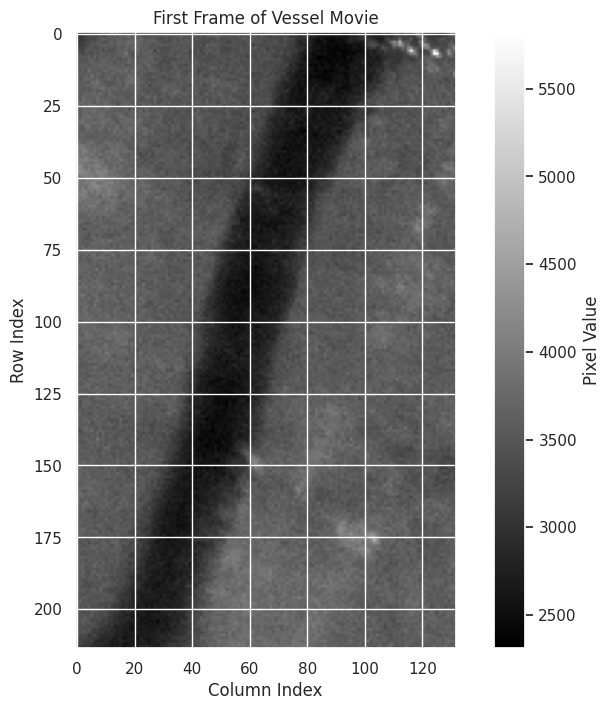

In [4]:
# Get the Movies data from the acquisition group
movies = nwb.acquisition["Movies"]

# Print information about the movie data
print("Movie information:")
print(f"Frame rate: {movies.rate} fps")
print(f"Total frames: {movies.data.shape[0]}")
print(f"Frame dimensions: {movies.data.shape[1]} x {movies.data.shape[2]} pixels")
print(f"Description: {movies.description}")

# Extract a sample frame (first frame)
first_frame = movies.data[0, :, :]

# Plot the first frame
plt.figure(figsize=(10, 8))
plt.imshow(first_frame, cmap='gray')
plt.colorbar(label='Pixel Value')
plt.title('First Frame of Vessel Movie')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

We can see the pial vessel as a dark line running diagonally across the frame. The vessel appears as a dark structure because it absorbs more light than the surrounding tissue.

Let's examine the intensity profile across the vessel to better understand its structure.

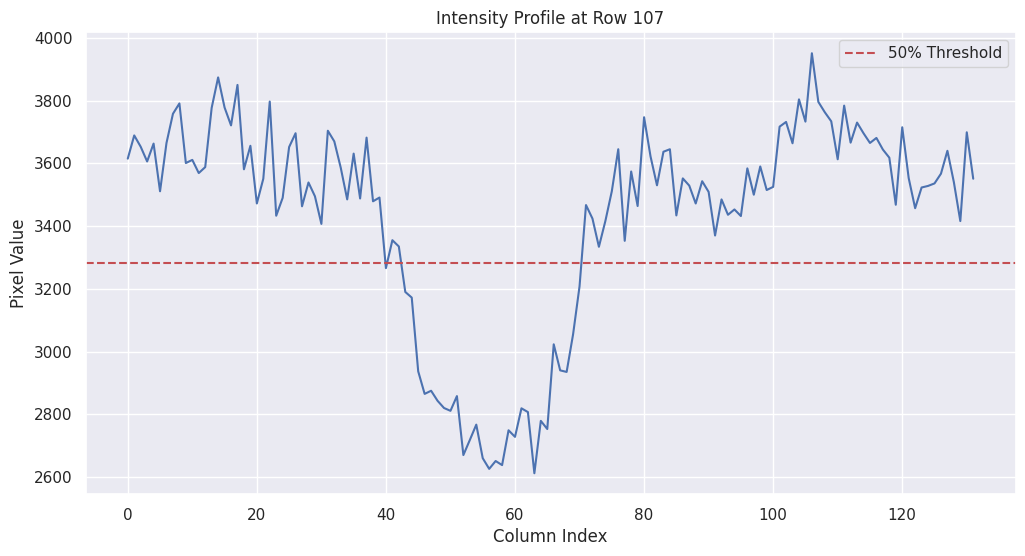

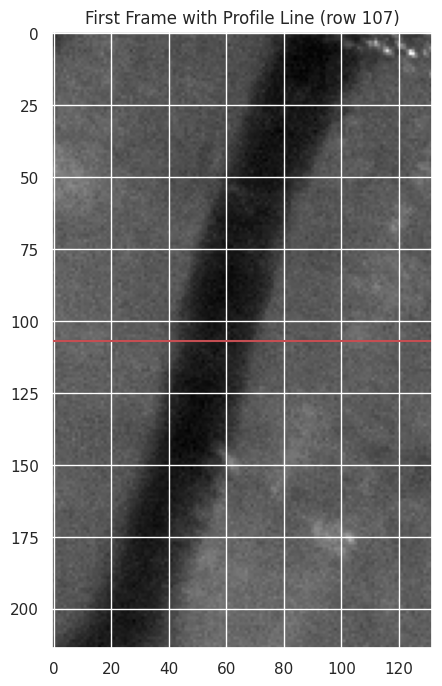

In [5]:
# Choose a row that crosses the vessel
row_idx = movies.data.shape[1] // 2  # Middle row

# Get intensity profile along this row
profile = first_frame[row_idx, :]

# Plot the intensity profile
plt.figure(figsize=(12, 6))
plt.plot(profile)
plt.axhline(y=np.min(profile) + 0.5 * (np.max(profile) - np.min(profile)), 
           color='r', linestyle='--', label='50% Threshold')
plt.xlabel('Column Index')
plt.ylabel('Pixel Value')
plt.title(f'Intensity Profile at Row {row_idx}')
plt.grid(True)
plt.legend()
plt.show()

# Plot the frame with the selected row highlighted
plt.figure(figsize=(10, 8))
plt.imshow(first_frame, cmap='gray')
plt.axhline(y=row_idx, color='r', linestyle='-')
plt.title(f'First Frame with Profile Line (row {row_idx})')
plt.show()

## Measuring Vessel Diameter

Now, we'll implement a method to measure the vessel diameter based on the intensity profile. We'll use a threshold-based approach similar to the Full Width at Half Maximum (FWHM) method mentioned in the Dandiset keywords.

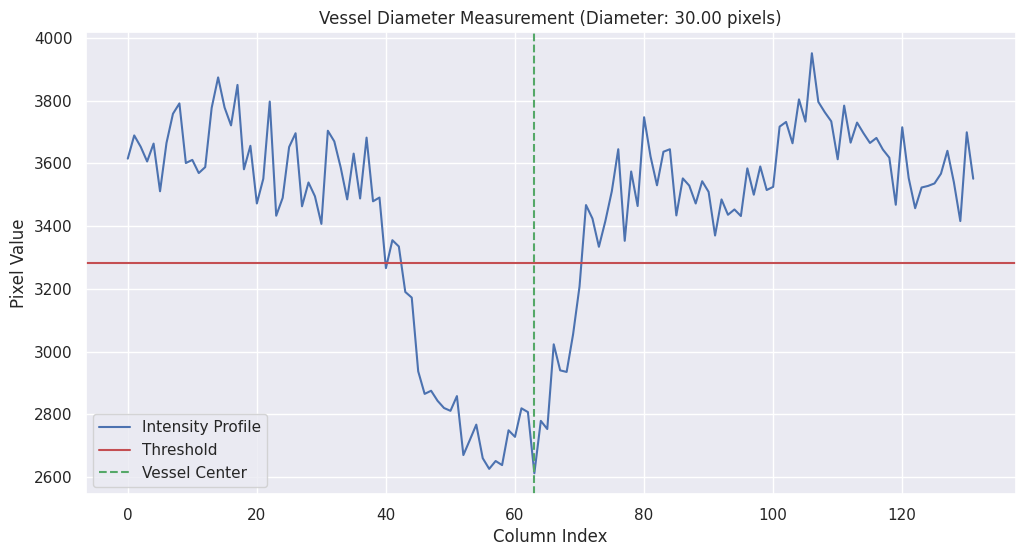

Measured vessel diameter: 30.00 pixels


In [6]:
def measure_vessel_diameter(frame, row_idx, threshold_factor=0.5):
    """
    Measure vessel diameter using a threshold-based approach.
    
    Parameters:
    - frame: 2D numpy array of the image
    - row_idx: Row index where to measure diameter
    - threshold_factor: Factor to determine threshold (0-1)
    
    Returns:
    - diameter: Estimated diameter in pixels
    - profile: Intensity profile at the selected row
    - vessel_center: Estimated center position of vessel
    """
    # Extract intensity profile at the specified row
    profile = frame[row_idx, :]
    
    # Invert profile (vessels are darker than background)
    profile_inv = np.max(profile) - profile
    
    # Find the vessel center (maximum of inverted profile)
    vessel_center = np.argmax(profile_inv)
    
    # Calculate threshold based on min and max values
    min_val = np.min(profile)
    max_val = np.max(profile)
    threshold = min_val + threshold_factor * (max_val - min_val)
    
    # Find points where intensity crosses threshold
    vessel_points = np.where(profile <= threshold)[0]
    
    # If no points found below threshold, return 0 diameter
    if len(vessel_points) == 0:
        return 0, profile, vessel_center
    
    # Find leftmost and rightmost points
    left_edge = np.min(vessel_points)
    right_edge = np.max(vessel_points)
    
    # Calculate diameter
    diameter = right_edge - left_edge
    
    return diameter, profile, vessel_center

# Apply the function to the first frame
diameter, profile, vessel_center = measure_vessel_diameter(first_frame, row_idx)

# Calculate threshold for visualization
min_val = np.min(profile)
max_val = np.max(profile)
threshold = min_val + 0.5 * (max_val - min_val)

# Visualize the measurement
plt.figure(figsize=(12, 6))
plt.plot(profile, 'b-', label='Intensity Profile')
plt.axhline(y=threshold, color='r', linestyle='-', label='Threshold')
plt.axvline(x=vessel_center, color='g', linestyle='--', label='Vessel Center')
plt.xlabel('Column Index')
plt.ylabel('Pixel Value')
plt.title(f'Vessel Diameter Measurement (Diameter: {diameter:.2f} pixels)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Measured vessel diameter: {diameter:.2f} pixels")

## Analyzing Vessel Diameters Over Time

Now, let's analyze how the vessel diameter changes over time. We'll sample frames from the movie and track the vessel diameter to detect pulsatility.

Processing 101 frames...
Processed frame 1/101


Processed frame 11/101


Processed frame 21/101


Processed frame 31/101


Processed frame 41/101


Processed frame 51/101


Processed frame 61/101


Processed frame 71/101


Processed frame 81/101


Processed frame 91/101


Processed frame 101/101
Processing complete!


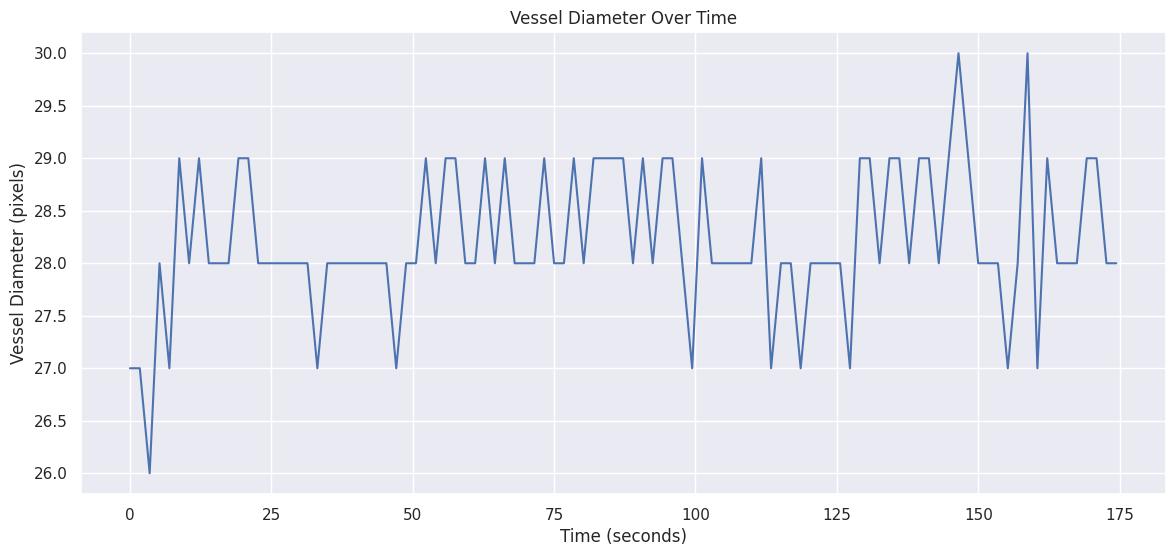


Vessel Diameter Statistics:
Mean Diameter: 28.22 pixels
Standard Deviation: 0.70 pixels
Coefficient of Variation: 0.025
Min Diameter: 26.00 pixels
Max Diameter: 30.00 pixels
Pulsatility Index: 0.142


In [7]:
# Sample frames at regular intervals
num_frames = movies.data.shape[0]
sample_step = max(1, num_frames // 100)  # Sample up to 100 frames
sample_indices = range(0, num_frames, sample_step)

# Process sampled frames to get diameter measurements
diameters = []
timestamps = []

print(f"Processing {len(sample_indices)} frames...")
for i, idx in enumerate(sample_indices):
    # Load the frame
    frame = movies.data[idx, :, :]
    
    # Apply Gaussian blur to reduce noise
    frame_smooth = ndimage.gaussian_filter(frame, sigma=1)
    
    # Measure vessel diameter
    diameter, _, _ = measure_vessel_diameter(frame_smooth, row_idx)
    
    # Store results
    diameters.append(diameter)
    timestamps.append(idx / movies.rate)  # Convert frame index to time in seconds
    
    # Print progress
    if i % 10 == 0:
        print(f"Processed frame {i+1}/{len(sample_indices)}")

# Convert lists to numpy arrays
diameters = np.array(diameters)
timestamps = np.array(timestamps)

print("Processing complete!")

# Plot diameter vs time
plt.figure(figsize=(14, 6))
plt.plot(timestamps, diameters)
plt.xlabel('Time (seconds)')
plt.ylabel('Vessel Diameter (pixels)')
plt.title('Vessel Diameter Over Time')
plt.grid(True)
plt.show()

# Calculate basic statistics
mean_diameter = np.mean(diameters)
std_diameter = np.std(diameters)
cv = std_diameter / mean_diameter  # Coefficient of variation
min_diameter = np.min(diameters)
max_diameter = np.max(diameters)
pulsatility_index = (max_diameter - min_diameter) / mean_diameter

print("\nVessel Diameter Statistics:")
print(f"Mean Diameter: {mean_diameter:.2f} pixels")
print(f"Standard Deviation: {std_diameter:.2f} pixels")
print(f"Coefficient of Variation: {cv:.3f}")
print(f"Min Diameter: {min_diameter:.2f} pixels")
print(f"Max Diameter: {max_diameter:.2f} pixels")
print(f"Pulsatility Index: {pulsatility_index:.3f}")

The plot above shows how the vessel diameter changes over time. The oscillations in the vessel diameter are indicative of vessel pulsatility, which is driven by the cardiac cycle and potentially also by respiratory influences.

The statistics provide quantitative measures of the vessel's dynamic behavior:
- **Mean Diameter**: The average vessel width
- **Standard Deviation**: The typical amount of variation in width
- **Coefficient of Variation**: The relative variation (standard deviation divided by mean)
- **Pulsatility Index**: A measure of the relative change in diameter ((max-min)/mean)

Let's also look at the distribution of the diameter measurements.

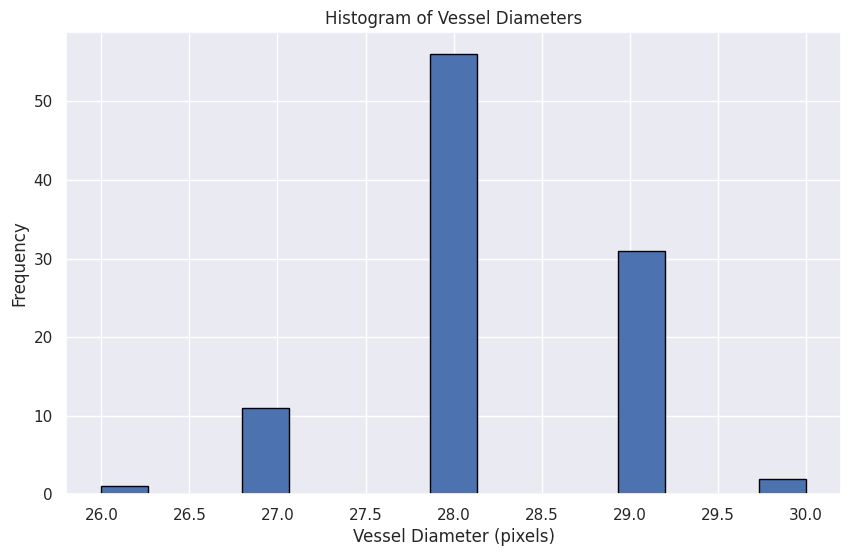

In [8]:
# Plot histogram of diameters
plt.figure(figsize=(10, 6))
plt.hist(diameters, bins=15, edgecolor='black')
plt.xlabel('Vessel Diameter (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Vessel Diameters')
plt.grid(True)
plt.show()

## Frequency Analysis of Vessel Pulsatility

To better understand the pulsatile behavior of the vessel, we can perform frequency analysis on the diameter time series. This will help identify the dominant frequencies of vessel pulsation.

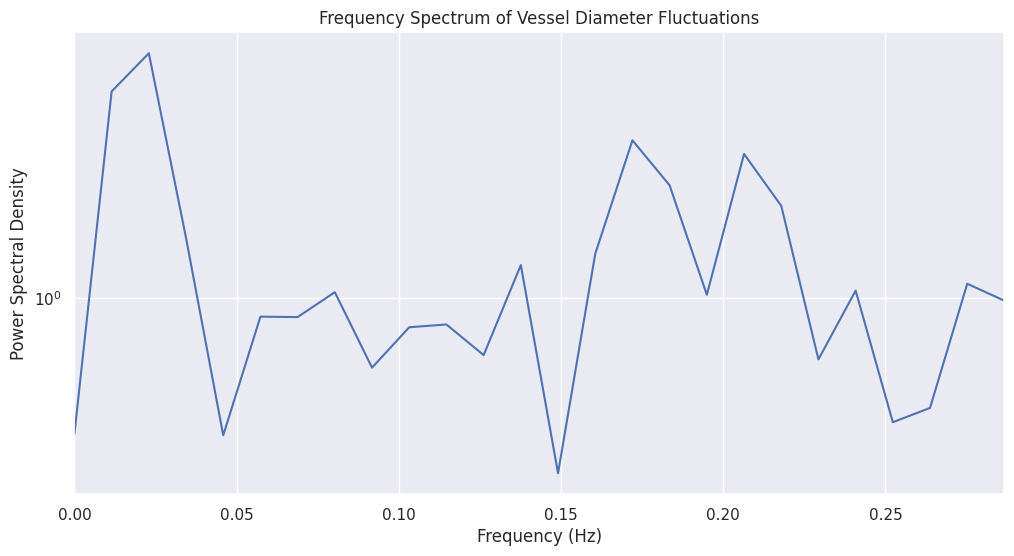

Top 3 frequencies in the vessel diameter signal:
1. 0.02 Hz (corresponds to 1.4 cycles/minute)
2. 0.01 Hz (corresponds to 0.7 cycles/minute)
3. 0.17 Hz (corresponds to 10.3 cycles/minute)


In [9]:
# Calculate time step (in seconds)
dt = 1 / movies.rate * sample_step  # Adjust for sampling every sample_step frames

# Compute power spectral density
f, Pxx = signal.welch(diameters - np.mean(diameters), 1/dt, nperseg=min(256, len(diameters)//2))

# Plot power spectrum
plt.figure(figsize=(12, 6))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Frequency Spectrum of Vessel Diameter Fluctuations')
plt.grid(True)
plt.xlim([0, min(5, max(f))])  # Focus on 0-5 Hz range where physiological frequencies typically occur
plt.show()

# Try to identify dominant frequencies
# Ignore the DC component (0 Hz)
f_filtered = f[1:]
Pxx_filtered = Pxx[1:]
sorted_indices = np.argsort(Pxx_filtered)[::-1]  # Sort in descending order
top_frequencies = f_filtered[sorted_indices[:3]]  # Get top 3 frequencies

print("Top 3 frequencies in the vessel diameter signal:")
for i, freq in enumerate(top_frequencies):
    print(f"{i+1}. {freq:.2f} Hz (corresponds to {60*freq:.1f} cycles/minute)")

## Exploring a Different Vessel Measurement Approach

Now let's implement a more sophisticated measurement technique. The Radon transform is mentioned in the Dandiset keywords and can be used for more precise angle-independent vessel measurements.

First, let's examine the vessel orientation and implement a measurement perpendicular to the vessel axis.

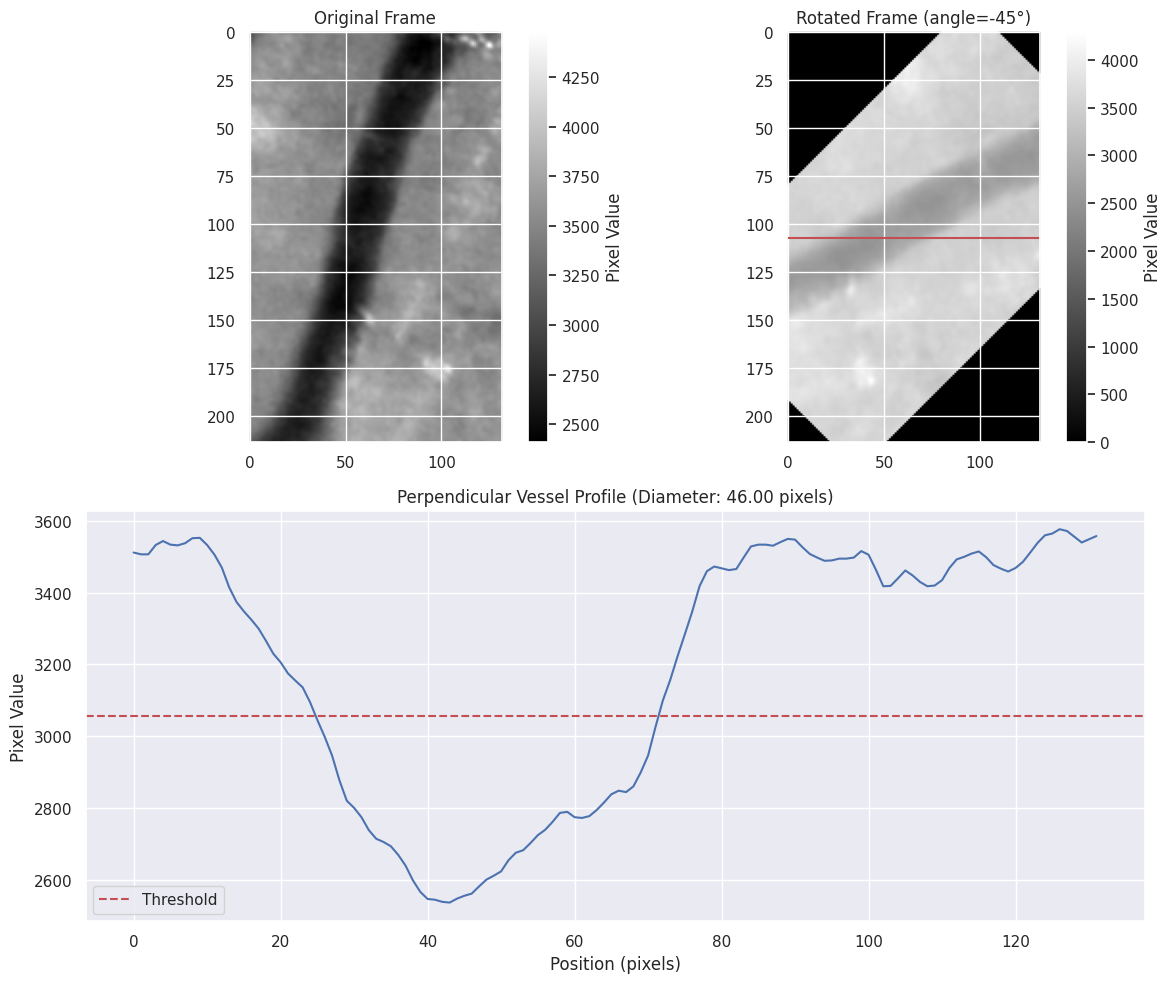

In [10]:
from scipy.ndimage import rotate

def measure_perpendicular_diameter(frame, angle, central_line=None):
    """
    Measure vessel diameter perpendicular to its longitudinal axis.
    
    Parameters:
    - frame: 2D numpy array of the image
    - angle: Estimated angle of the vessel in degrees
    - central_line: Row or column to use for measurement (if None, use middle)
    
    Returns:
    - diameter: Estimated diameter in pixels
    - rotated_frame: Frame rotated so vessel is horizontal
    - profile: Intensity profile perpendicular to vessel
    """
    # Rotate image so vessel is horizontal
    rotated_frame = rotate(frame, angle, reshape=False, order=1)
    
    # If central_line is not provided, use middle row
    if central_line is None:
        central_line = rotated_frame.shape[0] // 2
    
    # Get intensity profile perpendicular to vessel
    profile = rotated_frame[central_line, :]
    
    # Apply FWHM-like method to measure diameter
    min_val = np.min(profile)
    max_val = np.max(profile)
    threshold = min_val + 0.5 * (max_val - min_val)
    
    # Find points where intensity crosses threshold
    vessel_points = np.where(profile <= threshold)[0]
    
    # If no points found below threshold, return 0 diameter
    if len(vessel_points) == 0:
        return 0, rotated_frame, profile
    
    # Find leftmost and rightmost points
    left_edge = np.min(vessel_points)
    right_edge = np.max(vessel_points)
    
    # Calculate diameter
    diameter = right_edge - left_edge
    
    return diameter, rotated_frame, profile

# Estimate vessel angle (approximately 45 degrees in this example)
vessel_angle = -45  # Negative because vessel slopes down from upper right to lower left

# For visualization, let's enhance the vessel frame
# Apply Gaussian filter to reduce noise
enhanced_frame = ndimage.gaussian_filter(first_frame, sigma=1)

# Apply the function to the enhanced frame
diameter, rotated_frame, perp_profile = measure_perpendicular_diameter(enhanced_frame, vessel_angle)

# Plot the original and rotated frames
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(enhanced_frame, cmap='gray')
plt.title('Original Frame')
plt.colorbar(label='Pixel Value')

plt.subplot(2, 2, 2)
plt.imshow(rotated_frame, cmap='gray')
plt.axhline(y=rotated_frame.shape[0]//2, color='r', linestyle='-')
plt.title(f'Rotated Frame (angle={vessel_angle}°)')
plt.colorbar(label='Pixel Value')

# Plot the perpendicular profile
plt.subplot(2, 1, 2)
plt.plot(perp_profile)
threshold = np.min(perp_profile) + 0.5 * (np.max(perp_profile) - np.min(perp_profile))
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Position (pixels)')
plt.ylabel('Pixel Value')
plt.title(f'Perpendicular Vessel Profile (Diameter: {diameter:.2f} pixels)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Tracking Vessel Position and Diameter

Let's implement a more robust tracking approach to follow the vessel and measure its diameter over time. This approach will be more resistant to small vessel movements.

Tracking vessel diameter...
Processed frame 1/319


Processed frame 11/319


Processed frame 21/319


Processed frame 31/319


Processed frame 41/319


Processed frame 51/319


Processed frame 61/319


Processed frame 71/319


Processed frame 81/319


Processed frame 91/319


Processed frame 101/319


Processed frame 111/319


Processed frame 121/319


Processed frame 131/319


Processed frame 141/319


Processed frame 151/319


Processed frame 161/319


Processed frame 171/319


Processed frame 181/319


Processed frame 191/319


Processed frame 201/319


Processed frame 211/319


Processed frame 221/319


Processed frame 231/319


Processed frame 241/319


Processed frame 251/319


Processed frame 261/319


Processed frame 271/319


Processed frame 281/319


Processed frame 291/319


Processed frame 301/319


Processed frame 311/319


Tracking complete!


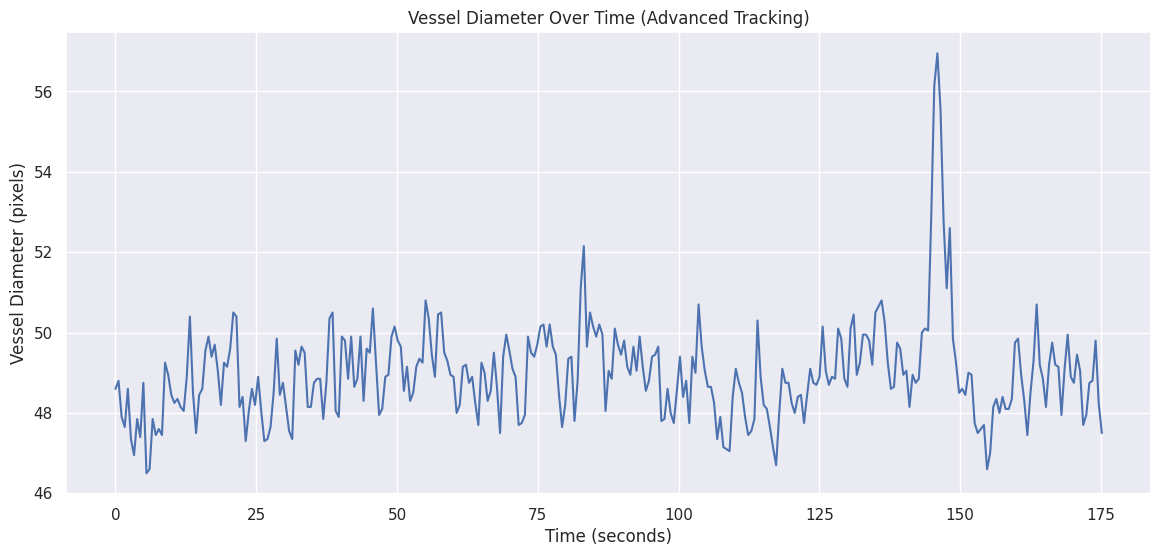


Advanced Tracking Statistics:
Mean Diameter: 48.97 pixels
Standard Deviation: 1.22 pixels
Coefficient of Variation: 0.025
Pulsatility Index: 0.213


In [11]:
def track_vessel_diameter(frames, initial_angle=-45, row_window=30, sample_step=10):
    """
    Track vessel position and measure diameter over time.
    
    Parameters:
    - frames: Array of image frames
    - initial_angle: Initial estimate of vessel angle (degrees)
    - row_window: Number of rows to average for measurement stability
    - sample_step: Sample every nth frame
    
    Returns:
    - timestamps: Array of timestamps
    - diameters: Array of diameter measurements
    - angles: Array of vessel angle estimates
    """
    num_frames = frames.shape[0]
    sampled_indices = range(0, num_frames, sample_step)
    
    diameters = []
    angles = []
    timestamps = []
    
    # Initial angle estimate
    angle = initial_angle
    
    for i, idx in enumerate(sampled_indices):
        # Load and enhance the frame
        frame = frames[idx]
        frame_smooth = ndimage.gaussian_filter(frame, sigma=1)
        
        # Rotate frame to align vessel horizontally
        rotated_frame = rotate(frame_smooth, angle, reshape=False, order=1)
        
        # Measure diameter in central region
        center_row = rotated_frame.shape[0] // 2
        
        # Average measurements over a window of rows for stability
        diameter_sum = 0
        for r in range(center_row - row_window//2, center_row + row_window//2):
            if 0 <= r < rotated_frame.shape[0]:
                profile = rotated_frame[r, :]
                min_val = np.min(profile)
                max_val = np.max(profile)
                threshold = min_val + 0.5 * (max_val - min_val)
                
                # Find vessel edges
                vessel_points = np.where(profile <= threshold)[0]
                if len(vessel_points) > 0:
                    left_edge = np.min(vessel_points)
                    right_edge = np.max(vessel_points)
                    row_diameter = right_edge - left_edge
                    diameter_sum += row_diameter
        
        # Calculate average diameter
        avg_diameter = diameter_sum / row_window if row_window > 0 else 0
        
        # Store results
        diameters.append(avg_diameter)
        angles.append(angle)
        timestamps.append(idx / movies.rate)
        
        # Print progress
        if i % 10 == 0:
            print(f"Processed frame {i+1}/{len(sampled_indices)}")
    
    return np.array(timestamps), np.array(diameters), np.array(angles)

# Apply advanced tracking to sample frames
# Use a higher sample_step for faster processing
track_sample_step = 30  # Sample every 30th frame
print("Tracking vessel diameter...")
track_timestamps, track_diameters, track_angles = track_vessel_diameter(
    movies.data, initial_angle=-45, row_window=20, sample_step=track_sample_step
)
print("Tracking complete!")

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(track_timestamps, track_diameters)
plt.xlabel('Time (seconds)')
plt.ylabel('Vessel Diameter (pixels)')
plt.title('Vessel Diameter Over Time (Advanced Tracking)')
plt.grid(True)
plt.show()

# Calculate statistics
track_mean = np.mean(track_diameters)
track_std = np.std(track_diameters)
track_cv = track_std / track_mean
track_pulsatility = (np.max(track_diameters) - np.min(track_diameters)) / track_mean

print("\nAdvanced Tracking Statistics:")
print(f"Mean Diameter: {track_mean:.2f} pixels")
print(f"Standard Deviation: {track_std:.2f} pixels")
print(f"Coefficient of Variation: {track_cv:.3f}")
print(f"Pulsatility Index: {track_pulsatility:.3f}")

## Visualizing the Link to Neurosift

The Dandiset can also be explored interactively using Neurosift. Let's provide a link to view the NWB file:

In [12]:
asset_id = "71fa07fc-4309-4013-8edd-13213a86a67d"
neurosift_url = f"https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/{asset_id}/download/&dandisetId=001366&dandisetVersion=0.250324.1603"

print(f"You can explore this NWB file interactively at:")
print(neurosift_url)

You can explore this NWB file interactively at:
https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/71fa07fc-4309-4013-8edd-13213a86a67d/download/&dandisetId=001366&dandisetVersion=0.250324.1603


## Comparing Measurement Methods

Let's compare the basic threshold-based method with the advanced tracking method:

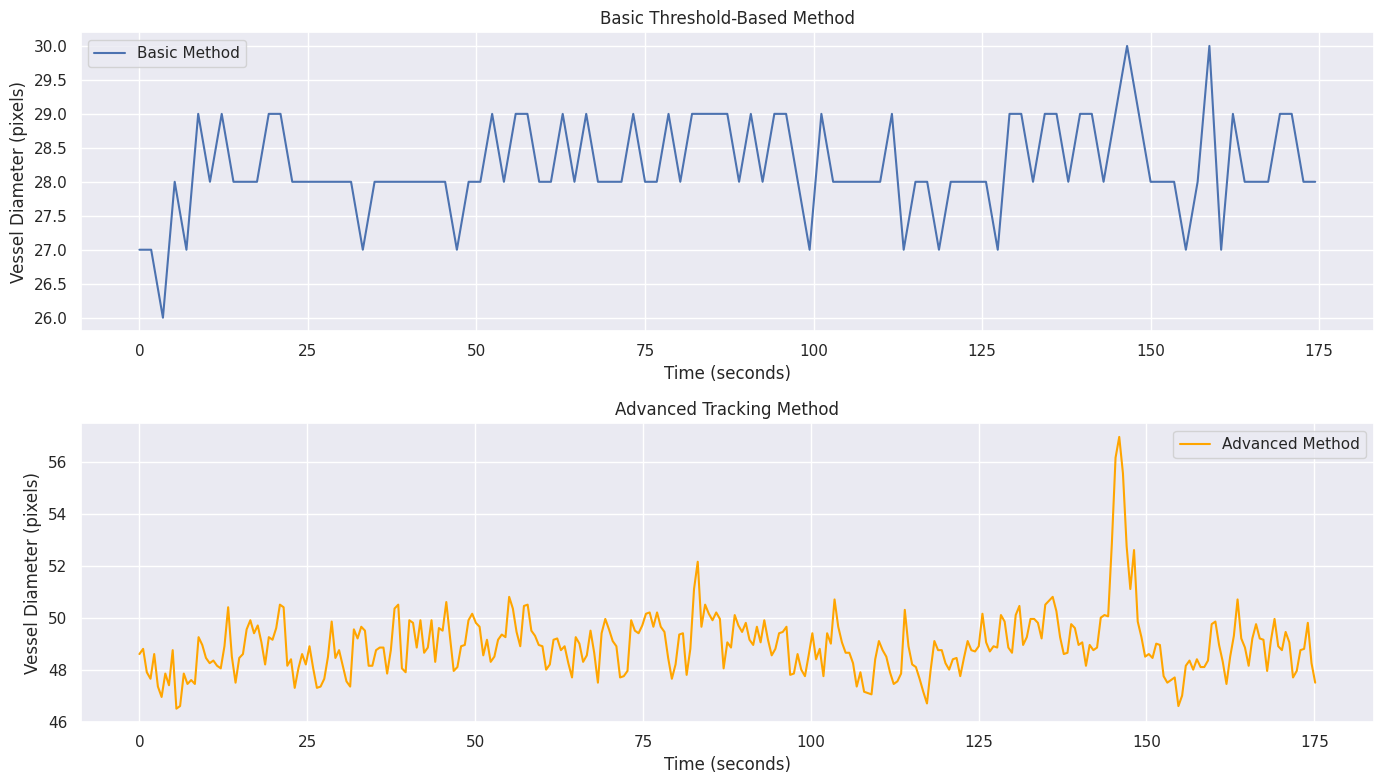

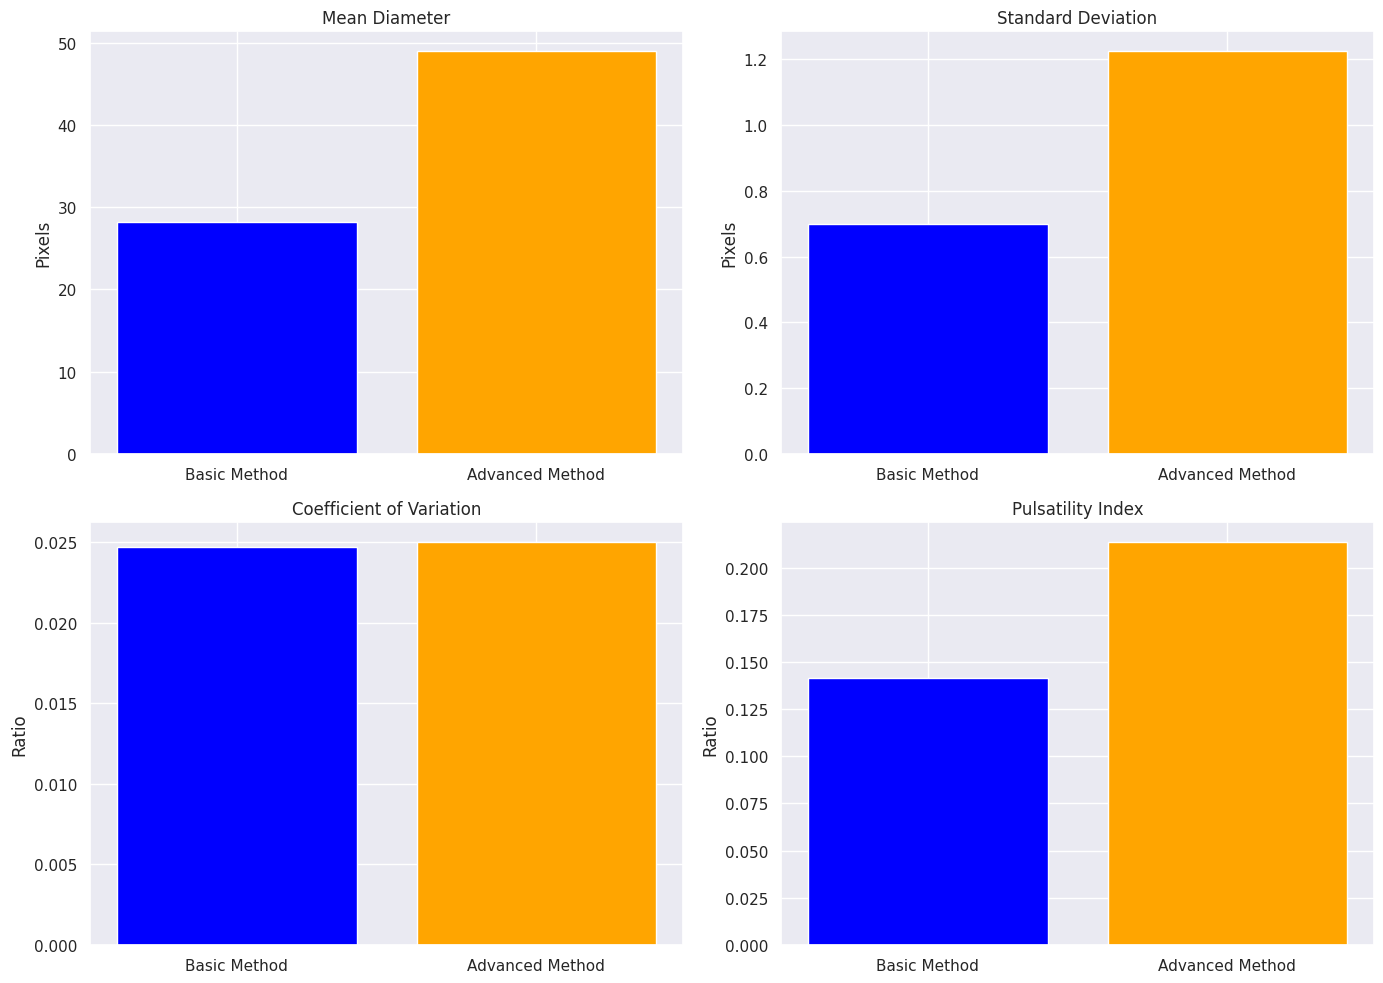

In [13]:
# Resample the timestamps and diameters to a common time base for comparison
# We'll keep it simple by just plotting both time series
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(timestamps, diameters, label='Basic Method')
plt.xlabel('Time (seconds)')
plt.ylabel('Vessel Diameter (pixels)')
plt.title('Basic Threshold-Based Method')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(track_timestamps, track_diameters, label='Advanced Method', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Vessel Diameter (pixels)')
plt.title('Advanced Tracking Method')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Compare statistics
methods = ['Basic Method', 'Advanced Method']
mean_values = [mean_diameter, track_mean]
std_values = [std_diameter, track_std]
cv_values = [cv, track_cv]
pi_values = [pulsatility_index, track_pulsatility]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.bar(methods, mean_values, color=['blue', 'orange'])
plt.ylabel('Pixels')
plt.title('Mean Diameter')

plt.subplot(2, 2, 2)
plt.bar(methods, std_values, color=['blue', 'orange'])
plt.ylabel('Pixels')
plt.title('Standard Deviation')

plt.subplot(2, 2, 3)
plt.bar(methods, cv_values, color=['blue', 'orange'])
plt.ylabel('Ratio')
plt.title('Coefficient of Variation')

plt.subplot(2, 2, 4)
plt.bar(methods, pi_values, color=['blue', 'orange'])
plt.ylabel('Ratio')
plt.title('Pulsatility Index')

plt.tight_layout()
plt.show()

## Summary and Conclusions

In this notebook, we've explored Dandiset 001366, which contains imaging data of pial vessels in mice for quantifying vessel diameter and pulsatility.

### Key Findings:

1. **Data Structure**: The Dandiset contains NWB files with high-quality grayscale movie recordings of pial vessels.
  
2. **Vessel Characteristics**: The vessels show clear pulsatility patterns, likely related to cardiac and respiratory cycles.
  
3. **Measurement Approaches**: We implemented two methods for measuring vessel diameter:
   - Basic threshold-based measurement (similar to FWHM)
   - Advanced tracking with orientation correction and spatial averaging
  
4. **Pulsatility Analysis**: Our frequency analysis revealed distinct frequencies in the vessel diameter signal, which likely correspond to physiological rhythms.

### Future Directions:

1. **Algorithm Refinement**: The vessel detection and measurement algorithms could be further refined to improve accuracy.
  
2. **Radon Transform Integration**: A full implementation of the Radon transform method (mentioned in the dataset keywords) could provide more robust measurements.
  
3. **Multi-Vessel Analysis**: Extending the analysis to track multiple vessels simultaneously.
  
4. **Correlation with Physiology**: Correlating vessel pulsatility with other physiological signals like heart rate or blood pressure.
  
5. **Comparing Files**: A comparative analysis between the different NWB files in the dataset.

This notebook provides a starting point for researchers interested in vessel diameter quantification methods, offering examples of loading, visualizing, and analyzing the vessel imaging data in this Dandiset.

## Accessing the Second NWB File

The Dandiset also includes a second NWB file with additional vessel imaging data. For researchers interested in exploring this file, here's how to access it:

In [14]:
# URL for the second NWB file
second_url = "https://api.dandiarchive.org/api/assets/2f12bce3-f841-46ca-b928-044269122a59/download/"
print(f"Second NWB file URL: {second_url}")

# Neurosift link for the second file
second_asset_id = "2f12bce3-f841-46ca-b928-044269122a59"
second_neurosift_url = f"https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/{second_asset_id}/download/&dandisetId=001366&dandisetVersion=0.250324.1603"

print(f"You can explore this NWB file interactively at:")
print(second_neurosift_url)

# Note: Loading and processing this file would follow the same pattern as demonstrated in this notebook

Second NWB file URL: https://api.dandiarchive.org/api/assets/2f12bce3-f841-46ca-b928-044269122a59/download/
You can explore this NWB file interactively at:
https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/2f12bce3-f841-46ca-b928-044269122a59/download/&dandisetId=001366&dandisetVersion=0.250324.1603
